# UNIDAD 4 - PROYECTO: ANÁLISIS DE SENTIMIENTOS Y PREDICCIÓN.

## ALUMNO: 
## NÚMERO DE CONTROL:


## PRESENTACIÓN.

El siguiente proyecto consiste en emplear el análisis de sentimientos para tratar de predecir las calificaciones de una serie.

El dataset es sobre las calificaciones que recibió la adaptación al "live-action" el anime "OnePiece".

El dataset contiene las reseñas que se recibieron en la plataforma de Netflix, el dataset contiene información como:

* Título.
* Reseña.
* Fecha.
* Calificación.


## ETAPA 1: ANÁLISIS EXPLORATORIO DE LOS DATOS.

### Paso 1. Importe las librerías necesarias (pandas, numpy, seaborn, nltk, etc...)

### Paso 2. Cargue y muestre información del dataset; muestre información estadística de las columnas numéricas.

### Paso 3. Identifique los datos nulos: muestre las filas que contienen datos nulos (no se deben tratar aún).

### Paso 4. Muestre la distribución de la columna "Rating", haga un análisis de la distribución.

### Paso 5. Identifique si alguna de las columnas se puede convertir en categórica.


In [1]:
#Paso 1
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


In [2]:
#Paso 2
# Carga del CSV a un archivo tipo DataFrame por medio de pandas.
df = pd.read_csv("reviews.csv")
print(df.info())


#información estadistica de las columnas númericas
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Title   878 non-null    object 
 1   Review  878 non-null    object 
 2   Date    878 non-null    object 
 3   Rating  870 non-null    float64
dtypes: float64(1), object(3)
memory usage: 27.6+ KB
None
           Rating
count  870.000000
mean     8.517241
std      2.268826
min      1.000000
25%      8.000000
50%      9.000000
75%     10.000000
max     10.000000


In [3]:
#Paso 3
#identificando nulos
print(df.isnull().sum())

Title     0
Review    0
Date      0
Rating    8
dtype: int64


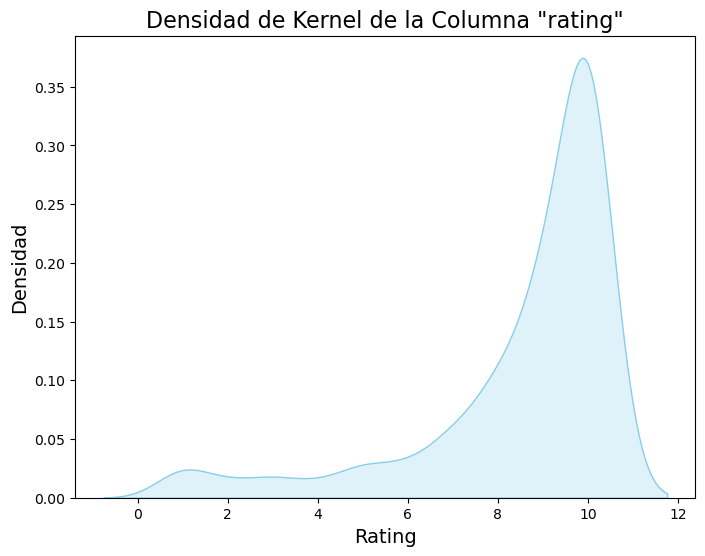

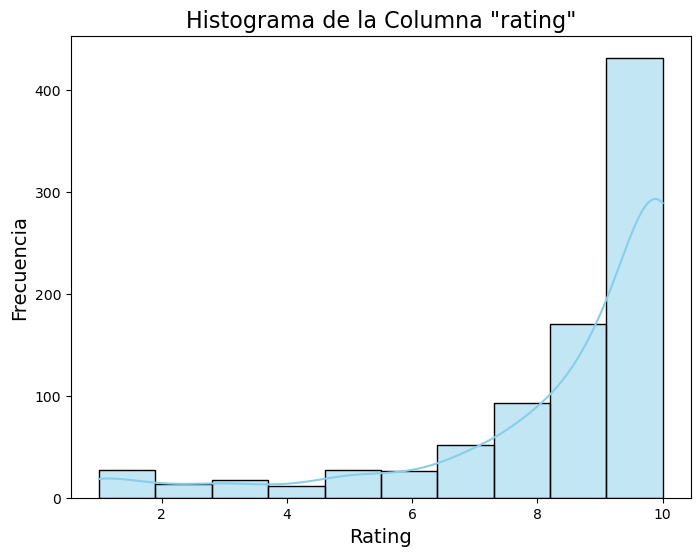

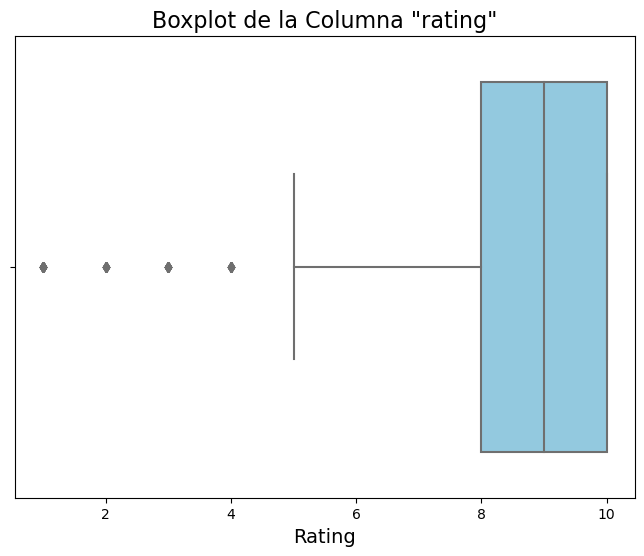

In [4]:
#Paso 4
#Grafico de densidad de kernel
plt.figure(figsize=(8, 6))
sns.kdeplot(df['Rating'], fill=True, color='skyblue')
plt.title('Densidad de Kernel de la Columna "rating"', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Densidad', fontsize=14)
plt.show()

#Histograma
plt.figure(figsize=(8, 6))
sns.histplot(df['Rating'], bins=10, kde=True, color='skyblue')
plt.title('Histograma de la Columna "rating"', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

#Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Rating'], color='skyblue')
plt.title('Boxplot de la Columna "rating"', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.show()

En el gráfico de densidad de kernel podemos apreciar que tenemos una distribución asimetrica con una pronunciada cola hacia la izquierda, en el histograma podemos observar que el dominio de la variable se extiende de 1 a 10 y la mayor parte de los datos se concentra en los valores altos del dominio. Finalmente en el Boxplot se confirma que mas del 50% de los datos se ubica entre los valores más altos de 8 a 10, la mediana es 9 y los valores donde rating es menor a 5 se consideran como outliers debido a la poca frecuencia que presentan en la variable. 

In [5]:
#Paso 5
#Analizando columnas objeto 
# Selecciona las columnas de tipo objeto (categóricas)
columnas_objeto = df.select_dtypes(include='object')

# Itera sobre las columnas de tipo objeto
for columna in columnas_objeto.columns:
    # Calcula y muestra la cantidad de valores únicos
    cantidad_valores_unicos = df[columna].nunique()
    print(f"Columna: {columna}")
    print(f"Cantidad de valores únicos: {cantidad_valores_unicos}")

    


Columna: Title
Cantidad de valores únicos: 878
Columna: Review
Cantidad de valores únicos: 878
Columna: Date
Cantidad de valores únicos: 40


In [6]:
#Analizando la columna "Date"
df_copy = df.copy()
df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='%d %B %Y')

# Extraer el mes de cada fecha y contar la frecuencia
frecuencia_meses = df_copy['Date'].dt.month_name().value_counts()

# Mostrar la frecuencia de los meses específicos
print("Frecuencia de August, September y October:")
print(frecuencia_meses[['August', 'September', 'October']])

Frecuencia de August, September y October:
August       136
September    724
October       18
Name: Date, dtype: int64


La columna "Title" y "Review" tienen entradas únicas para cada una de las observaciones de la variable y tampoco existe un patrón observable y útil para la categorización. Por otro lado la variable "Date" solo tiene 40 entradas únicas y podríamos pensar en una categorización a apartir del mes, sin embargo tampoco lo recomiendo debido a que una abrumadora cantidad de observaciones fueron hechas en "Septiembre" y la distribución de esta variable estaría extremadamente concentrada en este valor lo cual podría hacer a esta variable categorica poco útil para el analisis de datos. 

En conclusión ninguna variable de tipo objeto es candidata a convertirse en categorica. 

## ETAPA 2: ANÁLISIS DE SENTIMIENTOS.

### Paso 1. Muestre las primeras 10 filas del dataset con las columnas "Rating" y "Review", haga un análisis rápido de esa información.

### Paso 2. Haga una función que se encargue del pre-procesamiento:
#### - Genere los tokens.
#### - Filtre las palabras de parada.
#### - Obtenga el lema de las palabras y guárdelo en una lista.
#### - Retorne la lista en forma de una cadena, para ello debe unir los elementos de la lista mediante un espacio.

### Paso 3. Aplique la función creada para obtener el lema de las columnas "Review" y "Title", guárde el resultado en nuevas columnas dentro del dataframe original (por ejemplo: "ReviewText", "TitleText").

### Paso 4. Haga una función para obtener el sentimiento de las palabras, para ello puede utilizar el SentimentIntensityAnalizer() y su función "polarity_scores()". Al final debe retornar el puntaje de sentimiento.

### Paso 5. Aplique la función creada para obtener el sentimiento en las columnas creadas en el paso 3, guarde el resultado en un par de columnas nuevas (por ejemplo: "ReviewSentiment", "TitleSentiment").

### Paso 6. Prepare un dataframe con las columnas originales + las columnas creadas previamente, tendrían que haber 8 columnas, 3 de ellas deben ser numéricas (incluyendo "Rating").



In [7]:
#Paso 1
# Configurar la opción de visualización para mostrar el texto completo de las revisiones
pd.set_option('display.max_colwidth', None)

# Mostrar las primeras 10 filas de las columnas 'rating' y 'review'
primeras_10_filas = df[['Rating', 'Review']].head(10)

# Imprimir el resultado
print(primeras_10_filas)



   Rating  \
0     8.0   
1     9.0   
2     9.0   
3    10.0   
4    10.0   
5    10.0   
6     9.0   
7    10.0   
8     8.0   
9    10.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

<h3> Analisis</h3>

Los 10 reviews son positivos hacia el anime, evidentemente con diferentes grados de intensidad pero al fin y al cabo postivos. Los ratings son en su mayoria '10' y tenemos un par de '8' como rating mas bajos, me gustaría mencionar que a partir de mi apreciación y debido a que todos los reviews son postivos me sería muy dificil predecir si el review corresponde a un rating 8 o a un 10. 

In [8]:
#Paso 2
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\J7077\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\J7077\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\J7077\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
def preprocesar_texto(texto):
    # Tokenización
    tokens = word_tokenize(texto.lower())

    # Eliminación de stopwords
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lematización
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Unir los lemas en una cadena
    texto_preprocesado = ' '.join(lemmatized_tokens)

    return texto_preprocesado

In [10]:
#paso 3
# Aplicar la función a las columnas "Review" y "Title"
df['ReviewText'] = df['Review'].apply(preprocesar_texto)
df['TitleText'] = df['Title'].apply(preprocesar_texto)


In [11]:
#paso 4
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\J7077\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [12]:
# Instanciar el analizador de sentimientos VADER
sia = SentimentIntensityAnalyzer()

# Definir la función para obtener el puntaje de sentimiento
def obtener_puntaje_sentimiento(texto):
    # Obtener el puntaje de sentimiento con SentimentIntensityAnalyzer
    scores = sia.polarity_scores(texto)
    sentimiento = 1 if scores['pos'] > 0 else 0
    return sentimiento


In [13]:
#paso 5
# Aplicar la función a las columnas "ReviewText" y "TitleText"
df['ReviewSentiment'] = df['ReviewText'].apply(obtener_puntaje_sentimiento)
df['TitleSentiment'] = df['TitleText'].apply(obtener_puntaje_sentimiento)



In [14]:
#paso 6
print(df.info())
print(df.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            878 non-null    object 
 1   Review           878 non-null    object 
 2   Date             878 non-null    object 
 3   Rating           870 non-null    float64
 4   ReviewText       878 non-null    object 
 5   TitleText        878 non-null    object 
 6   ReviewSentiment  878 non-null    int64  
 7   TitleSentiment   878 non-null    int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 55.0+ KB
None
           Rating  ReviewSentiment  TitleSentiment
count  870.000000            878.0      878.000000
mean     8.517241              1.0        0.651481
std      2.268826              0.0        0.476773
min      1.000000              1.0        0.000000
25%      8.000000              1.0        0.000000
50%      9.000000              1.0        1.000000
75%     10.

## ETAPA 3: MACHINE LEARNING.

### Paso 1. Asigne a la variable X las columnas numéricas menos "Rating"; asigne a la variable y la columna "Rating", seleccione únicamente las filas sin datos nulos (no elimine ni trate las filas con datos nulos, esas se usarán para predecir)

### Paso 2. Divida en una muestra de entrenamiento y en una muestra de pruebas, estratifique en base a la proporción de la variable objetivo. El tamaño de la muestra para entrenamiento debe ser del 85%. Asigne una semilla para poder reproducir los resultados.

### Paso 3. Entrene los siguientes modelos:
#### - KNN para clasificación
#### - SVM para clasificación
#### - RandomForest para clasificación

### Paso 4. Evalúe el rendimiento de los modelos (puede usar accuracy) creados en el paso previo, muestre las predicciones realizadas y compare con las etiquetas reales.

### Paso 5. Debido a que este es un problema de clasificación, pero hay varias clases que son originalmente numéricas, se puede aplicar también una métrica de evaluación para regresión. Aplique el RMSE a las predicciones y las etiquetas reales, analice el resultado.

### Paso 6. Utilice el modelo que se comportó mejor para predecir el "Rating" de las filas que tienen ese dato nulo, revise manualmente si la calificación predicha es consistente con el comentario en la reseña.

### Paso 7. Escriba sus conclusiones al respecto.

In [15]:
#Paso 1

# Seleccionar únicamente las filas sin datos nulos
filas_sin_nulos = df.dropna(subset=['Rating'])

#Columnas numericas a la variable X a exception de rating 
X = filas_sin_nulos.drop(['Rating'], axis=1).select_dtypes(include='number')

# Asignar a la variable 'y' la columna "Rating"
y = filas_sin_nulos['Rating']


In [16]:
#Paso 2
from sklearn.model_selection import train_test_split

# Partir el conjunto de datos en entrenamiento y pruebas (85% entrenamiento, 15% pruebas)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, random_state=42)


In [17]:
#Paso 3 y 4 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Entrenar el modelo KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_knn = knn_model.predict(X_test)

# Calcular la precisión del modelo KNN
precision_knn = accuracy_score(y_test, y_pred_knn)
print("Precisión del modelo KNN:", precision_knn)

# Entrenar el modelo SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_svm = svm_model.predict(X_test)

# Calcular la precisión del modelo SVM
precision_svm = accuracy_score(y_test, y_pred_svm)
print("Precisión del modelo SVM:", precision_svm)

# Entrenar el modelo RandomForest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Calcular la precisión del modelo RandomForest
precision_rf = accuracy_score(y_test, y_pred_rf)
print("Precisión del modelo RandomForest:", precision_rf)


Precisión del modelo KNN: 0.5572519083969466
Precisión del modelo SVM: 0.5572519083969466
Precisión del modelo RandomForest: 0.5572519083969466


In [18]:
#Paso 5
from sklearn.metrics import mean_squared_error 
# Calcular el RMSE para KNN
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
print("RMSE para KNN:", rmse_knn)

# Calcular el RMSE para SVM
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
print("RMSE para SVM:", rmse_svm)

# Calcular el RMSE para RandomForest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("RMSE para RandomForest:", rmse_rf)


RMSE para KNN: 2.3198446907741426
RMSE para SVM: 2.3198446907741426
RMSE para RandomForest: 2.3198446907741426


In [19]:
#Paso 6
# Seleccionar las filas donde el valor de la columna "Rating" es nulo
null_rating_rows = df[df['Rating'].isnull()]

print(null_rating_rows.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 143 to 782
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            8 non-null      object 
 1   Review           8 non-null      object 
 2   Date             8 non-null      object 
 3   Rating           0 non-null      float64
 4   ReviewText       8 non-null      object 
 5   TitleText        8 non-null      object 
 6   ReviewSentiment  8 non-null      int64  
 7   TitleSentiment   8 non-null      int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 576.0+ bytes
None


In [20]:
X_final_test= null_rating_rows.drop(['Rating'], axis=1).select_dtypes(include='number')
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 870 entries, 0 to 877
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ReviewSentiment  870 non-null    int64
 1   TitleSentiment   870 non-null    int64
dtypes: int64(2)
memory usage: 20.4 KB
None


In [21]:
# Hacer predicciones con SVM
predicciones = svm_model.predict(X_final_test)

In [22]:
# Creando un dataframe para verificar las predicicones
df_predicciones = pd.DataFrame({
    'Rating' : predicciones,
    'Review' : null_rating_rows['Review']
})

In [23]:
# Mostrar las filas para revisión manual
print(df_predicciones[['Review', 'Rating']])

In [24]:
# Paso 7 Conclusiones

Conclusiones:

1. Las reseñas 145 y 569 son mayormente positvas sin embargo mi predicción es que no calificaron con un 10 en Rating. 
2. Las reseñas 500 y 540 son notoriamente negativas por lo que el modelo fallo gravemente en estos casos. 
3. Con el resto de las reseñas le concedo al modelo el beneficio de la duda, podrían considerarse como positivas y con una buena probabilidad de tener un 10 en Rating. 

A lo largo de esta actividad me di cuenta que el analizador de sentimientos califico todos los 'reviews' como positivos por lo que la caracteristica 'ReviewSentiment' se volvio totalmente inútil para el modelo de machine learning ya que no le permite diferenciar entre un rating bajo y uno alto. Desde el analisis exploratorio de los datos era evidente que teniamos una cantidad abrumadora de reseñas positivas lo cual probablemente sesgo al analizador de sentimientos y por consiguiente al modelo de machine learning. Debido a que el problema viene desde el analisis de sentimientos recomiendo usar técnicas mas avanzadas de machine learning para el analisis de los reviews. 

## ETAPA 4: PRESENTACIÓN DEL PROYECTO.
### Al igual que en los proyectos anteriores, suba su trabajo terminado a un repositorio nuevo de su GitHub.
### Escriba un archivo "README" y describa el proceso seguido en este trabajo.
### Al entregar este trabajo, debe subir este archivo, el archivo de instrucciones y el enlace al repositorio público de GitHub con este trabajo.